# Kelas Kolaborasi Kelompok 44

In [3]:
# Import

import ee
import geemap as geemap
from geemap import ml
import os
import numpy as np
import pandas as pd
import csv
from sklearn import ensemble, tree
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
# from matplotlib import pyplot as plt
# import seaborn as sns
# import missingno as mno

In [5]:
# Inisialisasi Map
Map = geemap.Map()

EDA: Insight about Data

In [15]:
sampleTraining = ee.FeatureCollection('projects/nadirafm/assets/2020_12')

# untuk export data KSA untuk dapat dilihat lebih lanjut
out_dir = os.path.expanduser("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\")
out_shp = os.path.join(out_dir, "KSA_2020_12.csv")
geemap.ee_export_vector(sampleTraining, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\nadira Fawziyya m\Documents\KULIAH\Sem 8\Siscer\TUBES\DATA\KSA_2020_12.csv


In [4]:
# Membaca file csv sampel KSA
df = pd.read_csv("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\KSA_2020_01.csv")
df

,x,y,nilai,system:index
0,107.214868,-6.351171,0,000000000000000005c4
1,107.214888,-6.350865,0,000000000000000005c5
2,107.214921,-6.350541,0,000000000000000005c6
3,107.214997,-6.350144,0,000000000000000005c7
4,107.215172,-6.349826,0,000000000000000005c8
...,...,...,...,...
4513,107.610816,-6.512660,7,000000000000000011a1
4514,107.617950,-6.516881,7,000000000000000011a2
4515,107.618360,-6.520191,7,000000000000000011a3
4516,107.616551,-6.522372,7,000000000000000011a4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4518 entries, 0 to 4517
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   x             4518 non-null   float64
 1   y             4518 non-null   float64
 2   nilai         4518 non-null   int64  
 3   system:index  4518 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 141.3+ KB


In [6]:
print('nilai: %s' % Counter(df["nilai"]))

nilai: Counter({0: 1979, 4: 1110, 7: 588, 6: 503, 1: 203, 2: 91, 3: 28, 5: 16})


<AxesSubplot:>

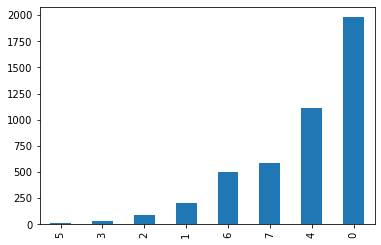

In [7]:
df.nilai.value_counts().sort_values().plot(kind = 'bar')

<AxesSubplot:>

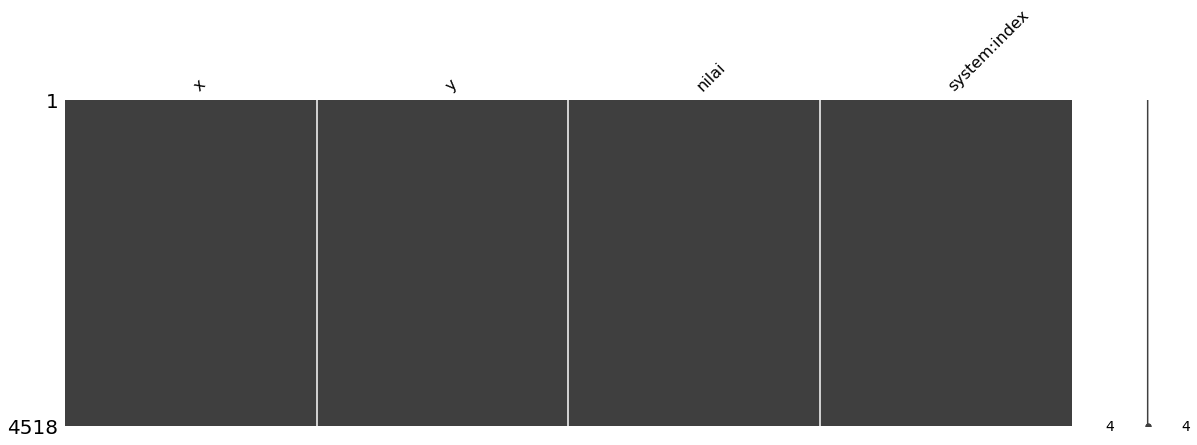

In [8]:
mno.matrix(df,figsize=(20,6))

- Dataset KSA tidak memiliki missing value
- Apabila ada, seharusnya grafik di atas menunjukkan gap putih dalam grafiknya

EDA : Data Colleting

In [9]:
#Convert 'nilai' property from string to number.
def func_vjt(feature):
    num = ee.Number.parse(feature.get('nilai'))
    return feature.set('nilai', num)
# Deklarasi Variabel
polygon = ee.FeatureCollection('projects/nadirafm/assets/polygonJaktim')
geometry = ee.FeatureCollection('projects/nadirafm/assets/kab_karawang')
sampleTraining = ee.FeatureCollection('projects/nadirafm/assets/2020_01').map(func_vjt)
L8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
LC8_BANDS = ['B2','B3','B4','B5','B6','B7','B10'] #Landsat 8
orbit = 'ASCENDING'

In [11]:
# Fungsi-fungsi yang dipakai
def func_train(image):
    return image.clip(geometry)
def func_predict(image):
    return image.clip(polygon)

# Fungsi menghasilkan variabel bertipe date
def get_bulan(m):
    global start_date, finish_date
    if (m==2013):
        start_date = ee.Date('2013-01-01')
        finish_date = ee.Date('2013-12-31')
    if (m==2015):
        start_date = ee.Date('2015-01-01')
        finish_date = ee.Date('2015-12-31')
    if (m==2017):
        start_date = ee.Date('2017-01-01')
        finish_date = ee.Date('2017-12-31')
    if (m==2019):
        start_date = ee.Date('2019-01-01')
        finish_date = ee.Date('2019-12-31')
    if (m==2020):
        start_date = ee.Date('2020-01-01')
        finish_date = ee.Date('2020-01-31')
    if (m==2021):
        start_date = ee.Date('2021-01-01')
        finish_date = ee.Date('2021-12-31')
    return start_date, finish_date

def get_L8 (m,n):
    start_date, finish_date = get_bulan(m)
    if (n=="training"):
        collectionL8 = ee.ImageCollection(L8).map(func_train) \
            .filterDate(start_date, finish_date) \
            .filterMetadata('CLOUD_COVER', 'less_than', 5) \
            .select(LC8_BANDS) \
            .filterBounds(geometry) \
            
    if (n=="prediksi"):
        collectionL8 = ee.ImageCollection(L8).map(func_predict) \
            .filterDate(start_date, finish_date) \
            .filterMetadata('CLOUD_COVER', 'less_than', 5) \
            .select(LC8_BANDS) \
            .filterBounds(polygon) \

    col2 = collectionL8.select('B2').median()
    col3 = collectionL8.select('B3').median()
    col4 = collectionL8.select('B4').median()
    col5 = collectionL8.select('B5').median()
    col6 = collectionL8.select('B6').median()
    col7 = collectionL8.select('B7').median()

    NDVI1 = col5.subtract(col4)
    NDVI2 = col5.add(col4)
    NDVI = NDVI1.divide(NDVI2)

    NDBI1 = col6.subtract(col5)
    NDBI2 = col6.add(col5)
    NDBI = NDBI1.divide(NDBI2)

    MNDWI1 = col3.subtract(col6)
    MNDWI2 = col3.add(col6)
    MNDWI = MNDWI1.divide(MNDWI2)

    BI1 = col7.add(col4)
    BI2 = col5.add(col2)
    BI3 = BI1.subtract(BI2)
    BI4= BI1.add(BI2)
    BI = BI3.divide(BI4)
    
    UI1 = col7.subtract(col5)
    UI2 = col7.add(col5)
    UI = UI1.divide(UI2)

    bandsall = ["0_B5","1_B6", "2_B3","3_B7","4_B7"]

    fincol = ee.ImageCollection([NDVI, NDBI,MNDWI, UI,BI])
    finLayer = fincol.toBands()
    # Membuat data Training seluruh bulan
    label = 'nilai'
    return finLayer, bandsall, label

In [12]:
# contoh memanggil fungsi penambilan data citra tahun 2020
finLayer, bandsall, label= get_L8(2020,"training") # data tipe feature collection
trainingall = finLayer.select(bandsall).sampleRegions(collection= sampleTraining, properties= [label], scale = 12)

In [13]:
# Export feature collection menjadi file csv di lokal
out_dir = os.path.expanduser("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\")
out_shp = os.path.join(out_dir, "KSA_L8_2020_01.csv")
geemap.ee_export_vector(trainingall, out_shp, verbose=True)

EEException: Image.select: Pattern '0_B5' did not match any bands.

Apabila bagian export ini error, dapat menggunakan kode java di Google Earth Engine dengan link berikut:
https://code.earthengine.google.com/07cd365fb7196bd1949bc1146189d44e
dengan menjalankan task untuk mengexport trainingall ke csv (disimpan di drive).
Lalu didownload ke local

In [14]:
# Membaca file csv yang telah didownload
df = pd.read_csv("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\KSA_L8_2020_01.csv")
df


,system:index,0_B5,1_B6,2_B3,3_B7,4_B7,nilai,.geo
0,000000000000000005c4_0,-0.014633,-0.523904,0.534440,-0.760458,-0.397880,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,000000000000000005c5_0,0.003964,-0.541995,0.539190,-0.784753,-0.404117,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,000000000000000005c6_0,0.007100,-0.561812,0.556933,-0.792673,-0.406784,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,000000000000000005c7_0,0.002862,-0.544991,0.542976,-0.788198,-0.403775,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,000000000000000005c8_0,-0.016848,-0.568497,0.579792,-0.797020,-0.396647,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
...,...,...,...,...,...,...,...,...
3502,00000000000000001183_0,0.137399,-0.212049,0.076891,-0.426184,-0.276268,7,"{""type"":""MultiPoint"",""coordinates"":[]}"
3503,00000000000000001184_0,0.138508,-0.125160,-0.013583,-0.298186,-0.176025,7,"{""type"":""MultiPoint"",""coordinates"":[]}"
3504,00000000000000001185_0,0.145949,-0.201134,0.056854,-0.460128,-0.283766,7,"{""type"":""MultiPoint"",""coordinates"":[]}"
3505,00000000000000001186_0,0.133681,0.068478,-0.200325,-0.005799,-0.057618,7,"{""type"":""MultiPoint"",""coordinates"":[]}"


Data Cleaning

In [15]:
df.rename(columns = {'0_B5':'NDVI', '1_B6':'NDBI','2_B3':'MNDWI','3_B7':'UI','4_B7':'BI'}, inplace = True)

In [16]:
print("Sebelum pengubahan Label Kelas:", Counter(df["nilai"]))
df["nilai"].replace(to_replace= 2, value = 1, inplace=True)
df["nilai"].replace(to_replace= 3, value = 1, inplace=True)
df["nilai"].replace(to_replace= 4, value = 1, inplace=True)
df["nilai"].replace(to_replace= 5, value = 1, inplace=True)
df["nilai"].replace(to_replace= 6, value = 2, inplace=True)
df["nilai"].replace(to_replace= 7, value = 3, inplace=True)
print("Setelah pengubahan Label Kelas:", Counter(df["nilai"]))

Sebelum pengubahan Label Kelas: Counter({0: 1455, 4: 1110, 6: 320, 7: 284, 1: 203, 2: 91, 3: 28, 5: 16})
Setelah pengubahan Label Kelas: Counter({0: 1455, 1: 1448, 2: 320, 3: 284})


Missing Value Detection

<AxesSubplot:>

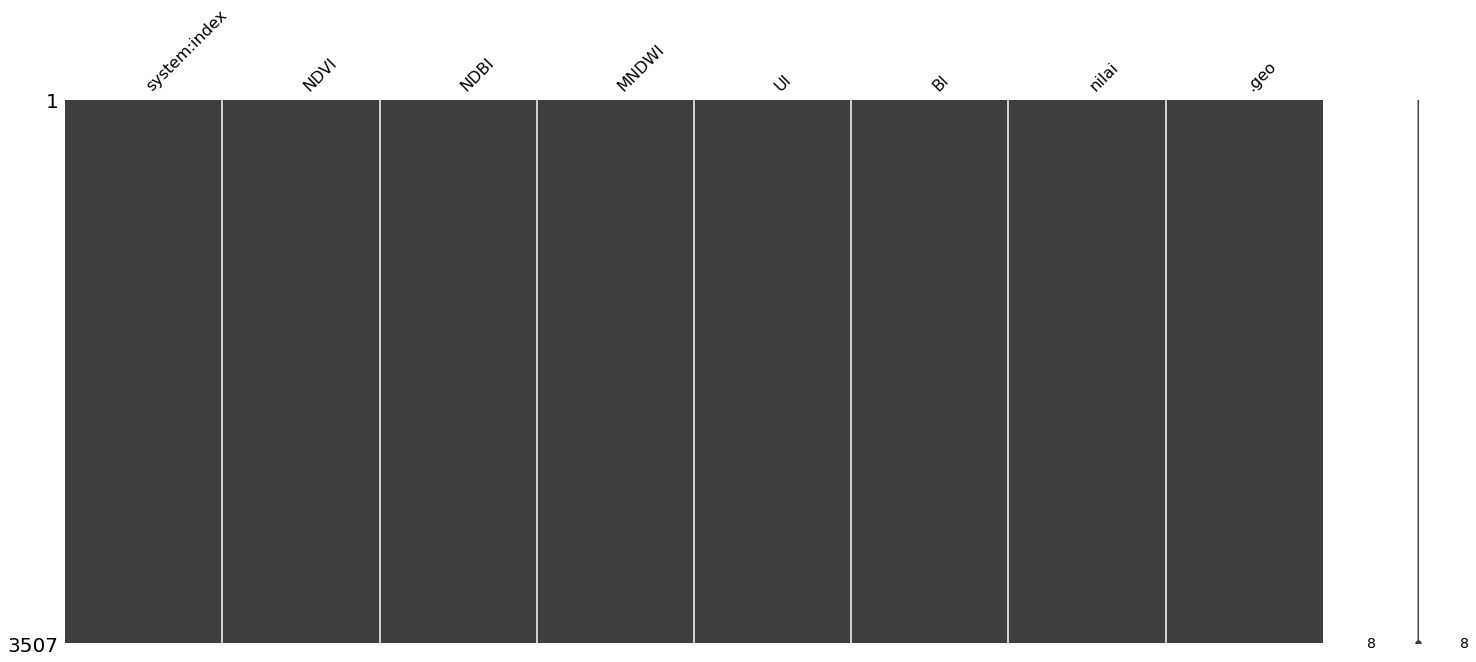

In [17]:
mno.matrix(df)

# berdasarkan grafik dibawah, terlihat bahwa data 
# ini tidak memiliki missing value di dalamnya.

- Dataset input tidak memiliki missing value
- Apabila ada, seharusnya grafik di atas menunjukkan gap putih dalam grafiknya

In [18]:
df.isnull().sum()

system:index    0
NDVI            0
NDBI            0
MNDWI           0
UI              0
BI              0
nilai           0
.geo            0
dtype: int64

In [19]:
df.dtypes

# Karena tipe atribut data yang akan dibutuhkan
# NDVI, NDBI, MNDWI, UI, BI, dan nilai bertipe numerik,
# Maka tidak ada data string di dalamnya.
# Data system: index menunjukkan urutan suatu baris data, dan
# kolom .geo menunjukkan data geometrik dari suatu sampel.
# Karena kedua data tersebut tidak dibutuhkan, maka akan didrop
# kedua kolom tersebut.

system:index     object
NDVI            float64
NDBI            float64
MNDWI           float64
UI              float64
BI              float64
nilai             int64
.geo             object
dtype: object

In [20]:
# drop kolom yang tidak dibutuhkan
df.drop(columns=["system:index",".geo"], inplace=True)
df

,NDVI,NDBI,MNDWI,UI,BI,nilai
0,-0.014633,-0.523904,0.534440,-0.760458,-0.397880,0
1,0.003964,-0.541995,0.539190,-0.784753,-0.404117,0
2,0.007100,-0.561812,0.556933,-0.792673,-0.406784,0
3,0.002862,-0.544991,0.542976,-0.788198,-0.403775,0
4,-0.016848,-0.568497,0.579792,-0.797020,-0.396647,0
...,...,...,...,...,...,...
3502,0.137399,-0.212049,0.076891,-0.426184,-0.276268,3
3503,0.138508,-0.125160,-0.013583,-0.298186,-0.176025,3
3504,0.145949,-0.201134,0.056854,-0.460128,-0.283766,3
3505,0.133681,0.068478,-0.200325,-0.005799,-0.057618,3


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3507 entries, 0 to 3506
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    3507 non-null   float64
 1   NDBI    3507 non-null   float64
 2   MNDWI   3507 non-null   float64
 3   UI      3507 non-null   float64
 4   BI      3507 non-null   float64
 5   nilai   3507 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 164.5 KB


In [22]:
df.head()

,NDVI,NDBI,MNDWI,UI,BI,nilai
0,-0.014633,-0.523904,0.534440,-0.760458,-0.397880,0
1,0.003964,-0.541995,0.539190,-0.784753,-0.404117,0
2,0.007100,-0.561812,0.556933,-0.792673,-0.406784,0
3,0.002862,-0.544991,0.542976,-0.788198,-0.403775,0
4,-0.016848,-0.568497,0.579792,-0.797020,-0.396647,0


In [23]:
df.describe()

,NDVI,NDBI,MNDWI,UI,BI,nilai
count,3507.000000,3507.000000,3507.000000,3507.000000,3507.000000,3507.000000
mean,0.118133,-0.277504,0.161032,-0.502866,-0.285990,0.838323
std,0.114055,0.159718,0.219308,0.192010,0.109984,0.896741
min,-0.353005,-0.683001,-0.482628,-0.852607,-0.604660,0.000000
25%,0.056804,-0.403220,-0.007487,-0.662338,-0.367731,0.000000
50%,0.104436,-0.272587,0.134780,-0.541359,-0.312016,1.000000
75%,0.174556,-0.140526,0.319611,-0.333193,-0.194912,1.000000
max,0.618587,0.249092,0.804589,0.270180,0.192532,3.000000


EDA: Feature Selection

<AxesSubplot:>

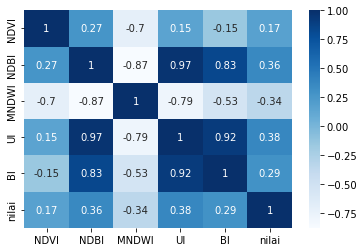

In [24]:
# Melihat graph korelasi masing2 fitur dengan kolom nilai
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(),cmap='Blues',annot=True) 

In [25]:
# karena semuanya berkorelasi cukup baik
# dengan kolom nilai, sehingga semua fitur akan dipakai
# sebagai data input.

<AxesSubplot:>

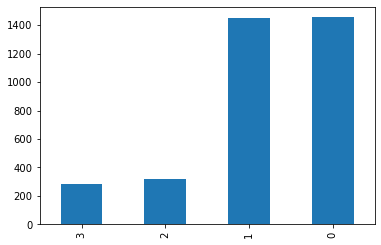

In [26]:
df.nilai.value_counts().sort_values().plot(kind = 'bar')

Data Skewness

In [27]:
df['NDVI'].skew()

0.3842599205184277

In [28]:
df['NDBI'].skew()

-0.11126562011284172

In [29]:
df['MNDWI'].skew()

0.31966441953550345

In [30]:
df['UI'].skew()

0.3693980990595114

In [31]:
df['BI'].skew()

0.32997076902367484

In [32]:
df['nilai'].skew()

0.9970373939516981

In [33]:
print(len(df.columns))

6


c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
c:\Users\nadira Fawziyya m\Anaconda3\envs\ge

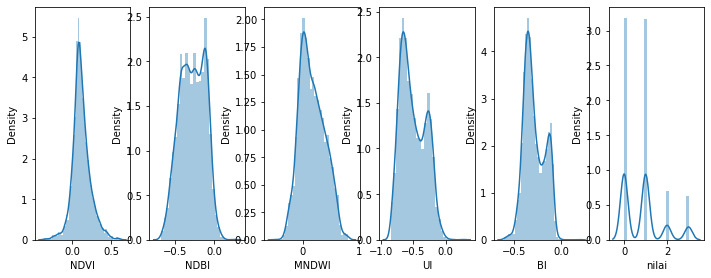

In [34]:
l = df.columns.values
plt.figure(figsize=(12,30))
for i in range(0,len(l)):
    plt.subplot(6,6,i+1)
    sns.distplot(df[l[i]],kde=True)

Outlier Detection

In [35]:
for i in range(len(df.columns)):
    if (df[df.columns[i]].dtypes in ['int64','float64']):
        print('\nAttribute-',i,':',df[df.columns[i]].dtypes)
        Q1=df[df.columns[i]].quantile(0.25)
        print('Q1',Q1)
        Q3=df[df.columns[i]].quantile(0.75)
        print('Q3',Q3)
        IQR=Q3-Q1
        print('IQR',IQR)
        min=df[df.columns[i]].min()
        max=df[df.columns[i]].max()
        
        min_IQR= Q1-1.5*IQR
        max_IQR= Q3+1.5*IQR
        if (int(min) < int(min_IQR)):
            print('Low outlier is found')
        if (max > max_IQR):
            print('High outlier is found')


Attribute- 0 : float64
Q1 0.05680386
Q3 0.17455631
IQR 0.11775245
High outlier is found

Attribute- 1 : float64
Q1 -0.403220325
Q3 -0.140526365
IQR 0.26269396

Attribute- 2 : float64
Q1 -0.007486524
Q3 0.319610595
IQR 0.327097119

Attribute- 3 : float64
Q1 -0.662338325
Q3 -0.33319266000000003
IQR 0.329145665
High outlier is found

Attribute- 4 : float64
Q1 -0.36773136
Q3 -0.19491247
IQR 0.17281889
High outlier is found

Attribute- 5 : int64
Q1 0.0
Q3 1.0
IQR 1.0
High outlier is found


EDA: Data Visualisasi-Boxplot

Text(0.5, 1.0, 'Nilai NDVI berdasarkan kelas')

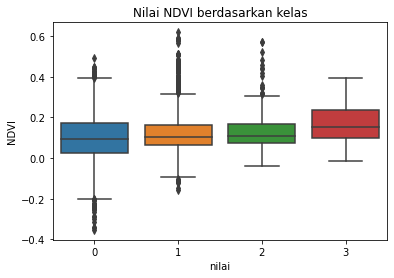

In [36]:
sns.boxplot(y=df["NDVI"], x = df["nilai"]).\
set_title('Nilai NDVI berdasarkan kelas')

Text(0.5, 1.0, 'Nilai NDBI berdasarkan kelas')

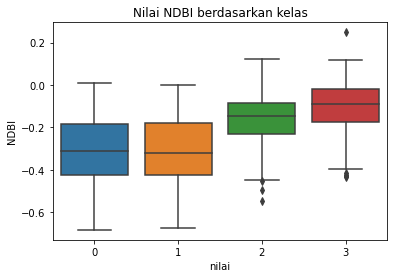

In [37]:
sns.boxplot(y=df["NDBI"], x = df["nilai"]).\
set_title('Nilai NDBI berdasarkan kelas')

Text(0.5, 1.0, 'Nilai MNDWI berdasarkan kelas')

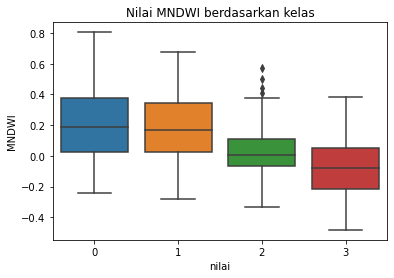

In [38]:
sns.boxplot(y=df["MNDWI"], x = df["nilai"]).\
set_title('Nilai MNDWI berdasarkan kelas')

Text(0.5, 1.0, 'Nilai UI berdasarkan kelas')

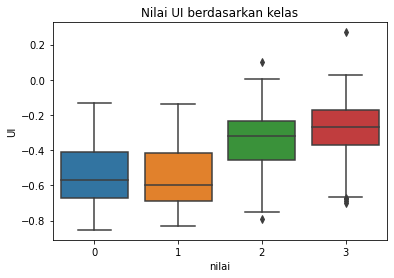

In [39]:
sns.boxplot(y=df["UI"], x = df["nilai"]).\
set_title('Nilai UI berdasarkan kelas')

Text(0.5, 1.0, 'Nilai BI berdasarkan kelas')

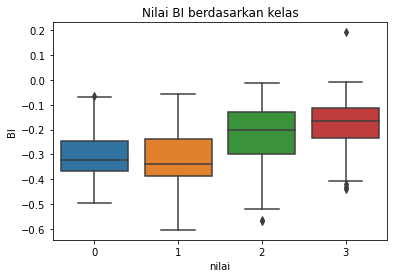

In [40]:
sns.boxplot(y=df["BI"], x = df["nilai"]).\
set_title('Nilai BI berdasarkan kelas')

Tampilan Dataframe akhir

In [41]:
df

,NDVI,NDBI,MNDWI,UI,BI,nilai
0,-0.014633,-0.523904,0.534440,-0.760458,-0.397880,0
1,0.003964,-0.541995,0.539190,-0.784753,-0.404117,0
2,0.007100,-0.561812,0.556933,-0.792673,-0.406784,0
3,0.002862,-0.544991,0.542976,-0.788198,-0.403775,0
4,-0.016848,-0.568497,0.579792,-0.797020,-0.396647,0
...,...,...,...,...,...,...
3502,0.137399,-0.212049,0.076891,-0.426184,-0.276268,3
3503,0.138508,-0.125160,-0.013583,-0.298186,-0.176025,3
3504,0.145949,-0.201134,0.056854,-0.460128,-0.283766,3
3505,0.133681,0.068478,-0.200325,-0.005799,-0.057618,3


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3507 entries, 0 to 3506
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    3507 non-null   float64
 1   NDBI    3507 non-null   float64
 2   MNDWI   3507 non-null   float64
 3   UI      3507 non-null   float64
 4   BI      3507 non-null   float64
 5   nilai   3507 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 164.5 KB


In [43]:
df.head(5)

,NDVI,NDBI,MNDWI,UI,BI,nilai
0,-0.014633,-0.523904,0.534440,-0.760458,-0.397880,0
1,0.003964,-0.541995,0.539190,-0.784753,-0.404117,0
2,0.007100,-0.561812,0.556933,-0.792673,-0.406784,0
3,0.002862,-0.544991,0.542976,-0.788198,-0.403775,0
4,-0.016848,-0.568497,0.579792,-0.797020,-0.396647,0


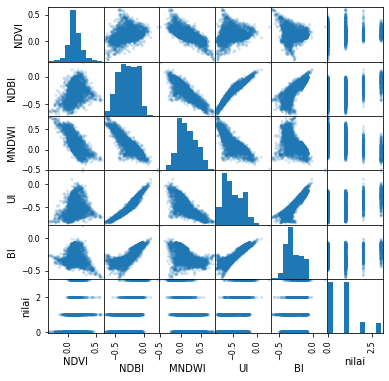

In [44]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='hist')
plt.show()

In [45]:
df.describe()

,NDVI,NDBI,MNDWI,UI,BI,nilai
count,3507.000000,3507.000000,3507.000000,3507.000000,3507.000000,3507.000000
mean,0.118133,-0.277504,0.161032,-0.502866,-0.285990,0.838323
std,0.114055,0.159718,0.219308,0.192010,0.109984,0.896741
min,-0.353005,-0.683001,-0.482628,-0.852607,-0.604660,0.000000
25%,0.056804,-0.403220,-0.007487,-0.662338,-0.367731,0.000000
50%,0.104436,-0.272587,0.134780,-0.541359,-0.312016,1.000000
75%,0.174556,-0.140526,0.319611,-0.333193,-0.194912,1.000000
max,0.618587,0.249092,0.804589,0.270180,0.192532,3.000000


In [46]:
df.dtypes

NDVI     float64
NDBI     float64
MNDWI    float64
UI       float64
BI       float64
nilai      int64
dtype: object

In [47]:
df.isnull().sum()

NDVI     0
NDBI     0
MNDWI    0
UI       0
BI       0
nilai    0
dtype: int64

Scatter Plot

[Text(0.5, 0, 'NDVI'), Text(0, 0.5, 'nilai')]

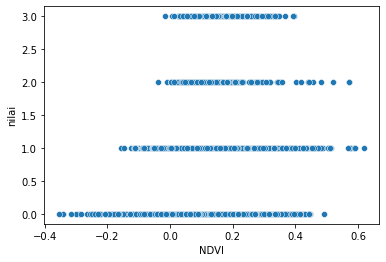

In [48]:
sns.scatterplot(x=df['NDVI'], y= df['nilai']).\
    set(xlabel='NDVI', ylabel = 'nilai')

[Text(0.5, 0, 'NDBI'), Text(0, 0.5, 'nilai')]

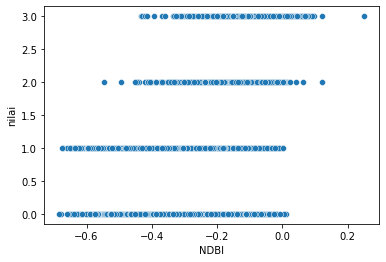

In [49]:
sns.scatterplot(x=df['NDBI'], y= df['nilai']).\
    set(xlabel='NDBI', ylabel = 'nilai')

[Text(0.5, 0, 'MNDWI'), Text(0, 0.5, 'nilai')]

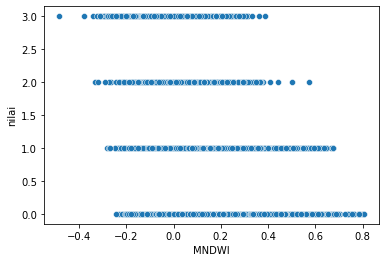

In [50]:
sns.scatterplot(x=df['MNDWI'], y= df['nilai']).\
    set(xlabel='MNDWI', ylabel = 'nilai')

[Text(0.5, 0, 'UI'), Text(0, 0.5, 'nilai')]

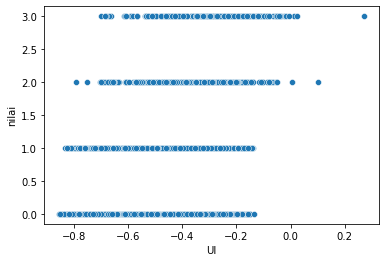

In [51]:
sns.scatterplot(x=df['UI'], y= df['nilai']).\
    set(xlabel='UI', ylabel = 'nilai')

[Text(0.5, 0, 'BI'), Text(0, 0.5, 'nilai')]

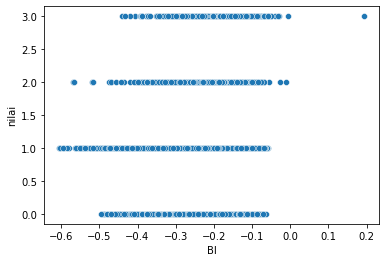

In [52]:
sns.scatterplot(x=df['BI'], y= df['nilai']).\
    set(xlabel='BI', ylabel = 'nilai')

# Data Preprocessing

Data Imbalance Handling

In [53]:
x = df[["NDVI","NDBI","MNDWI","UI","BI"]]
y = df[["nilai"]]
# Karena data yang tidak balance, maka perlu dilakukan imbalance handling dengan oversample
x_resampled, y_resampled = SMOTE().fit_resample(x,y)
print(sorted(Counter(y_resampled["nilai"]).items()))

[(0, 1455), (1, 1455), (2, 1455), (3, 1455)]


<AxesSubplot:>

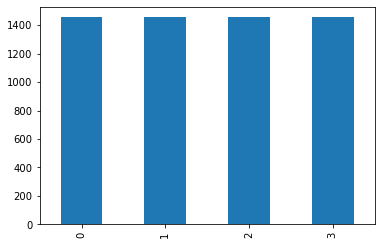

In [54]:
# Memeriksa kembali banyak data per kelas
y_resampled.nilai.value_counts().sort_values().plot(kind = 'bar')

Data Integration

In [55]:
df_resampled = pd.merge(x_resampled, y_resampled, left_index=True, right_index=True)
df_resampled

,NDVI,NDBI,MNDWI,UI,BI,nilai
0,-0.014633,-0.523904,0.534440,-0.760458,-0.397880,0
1,0.003964,-0.541995,0.539190,-0.784753,-0.404117,0
2,0.007100,-0.561812,0.556933,-0.792673,-0.406784,0
3,0.002862,-0.544991,0.542976,-0.788198,-0.403775,0
4,-0.016848,-0.568497,0.579792,-0.797020,-0.396647,0
...,...,...,...,...,...,...
5815,0.137261,-0.407634,0.286415,-0.678590,-0.419720,3
5816,0.248770,0.036596,-0.282777,-0.110557,-0.094198,3
5817,0.269465,-0.114409,-0.160007,-0.360359,-0.254786,3
5818,0.323057,-0.021701,-0.303479,-0.220606,-0.163766,3


Export Dataframe

In [ ]:
# Export Dataframe akhir
import os 
out_dir = os.path.expanduser("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\")
out_shp = os.path.join(out_dir, "KSA_2020_01_modified.csv")
df_resampled.to_csv(out_shp, index=False)

LOAD DATAFRAME

In [4]:
df = pd.read_csv("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\KSA_2020_01_modified.csv")
df

,NDVI,NDBI,MNDWI,UI,BI,nilai
0,-0.014633,-0.523904,0.534440,-0.760458,-0.397880,0
1,0.003964,-0.541995,0.539190,-0.784753,-0.404117,0
2,0.007100,-0.561812,0.556933,-0.792673,-0.406784,0
3,0.002862,-0.544991,0.542976,-0.788198,-0.403775,0
4,-0.016848,-0.568497,0.579792,-0.797020,-0.396647,0
...,...,...,...,...,...,...
5815,0.106627,-0.220924,0.117080,-0.434456,-0.277859,3
5816,0.064738,-0.129565,0.065373,-0.265431,-0.113259,3
5817,0.204289,-0.024977,-0.180221,-0.166898,-0.136091,3
5818,0.246841,0.046005,-0.289557,-0.108357,-0.094325,3


<AxesSubplot:>

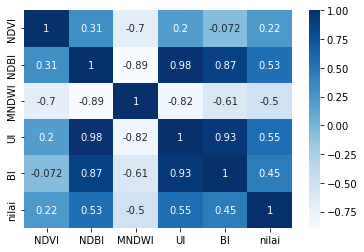

In [57]:
# Melihat graph korelasi masing2 fitur dengan kolom nilai
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(),cmap='Blues',annot=True) 

In [5]:
# Memisahkan data training dan testing
x = df[["NDVI","NDBI","MNDWI","UI","BI"]]
y = df[["nilai"]]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3,random_state=3)

# EKSPERIMEN

In [59]:
# EKSPERIMEN 1

# Random Forest
rf=RandomForestClassifier(random_state=2)
rf.fit(x_train, y_train)
y_predrf=rf.predict(x_test)
print("Random Forest:")
print(classification_report(y_test, y_predrf))
print("=======")

# Cart
cart= tree.DecisionTreeClassifier(random_state=2)
cart.fit(x_train, y_train)
print("CART/ Decision Tree:")
y_predcart=cart.predict(x_test)
print(classification_report(y_test, y_predcart))



c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Random Forest:
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       445
           1       0.62      0.64      0.63       431
           2       0.80      0.86      0.83       426
           3       0.82      0.86      0.84       444

    accuracy                           0.72      1746
   macro avg       0.72      0.72      0.72      1746
weighted avg       0.72      0.72      0.72      1746

CART/ Decision Tree:
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       445
           1       0.53      0.55      0.54       431
           2       0.75      0.74      0.74       426
           3       0.77      0.82      0.79       444

    accuracy                           0.66      1746
   macro avg       0.65      0.66      0.65      1746
weighted avg       0.65      0.66      0.65      1746



In [60]:
print("label kelas dalam data training:")
print(Counter(y_train["nilai"]))
print("label kelas dalam data test:")
print(Counter(y_test["nilai"]))

label kelas dalam data training:
Counter({2: 1029, 1: 1024, 3: 1011, 0: 1010})
label kelas dalam data test:
Counter({0: 445, 3: 444, 1: 431, 2: 426})


In [ ]:
# EKSPERIMEN 2

rf= RandomForestClassifier(random_state=2)
search_space= {
    "n_estimators": [10,20,50,100,300],
    "min_samples_split":[2,3,4,5,10,20,30,50],
    "min_samples_leaf":[1,2,3,4,5,10,20,30,50]
}

GS =GridSearchCV(estimator= rf,
                param_grid= search_space, 
                scoring="accuracy", 
                refit="precission",
                cv=5
)

In [ ]:
GS.fit(x_train,y_train)
print(GS.best_params_)

c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\skl

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
print(GS.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
rfuji= RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=2).fit(x_train,y_train)
y_predrf=rfuji.predict(x_test)
print(classification_report(y_test, y_predrf))

c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

           0       0.63      0.54      0.58       445
           1       0.62      0.64      0.63       431
           2       0.80      0.86      0.83       426
           3       0.82      0.86      0.84       444

    accuracy                           0.72      1746
   macro avg       0.72      0.72      0.72      1746
weighted avg       0.72      0.72      0.72      1746



Learning Curve

In [6]:
train_sizes, train_scores, test_scores = learning_curve(rf, 
                                                        x_train,y_train,
                                                        cv=5,
                                                        scoring="accuracy",
                                                        n_jobs=-1,
                                                        train_sizes =np.linspace(0.01,1.0,50))
 

In [7]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

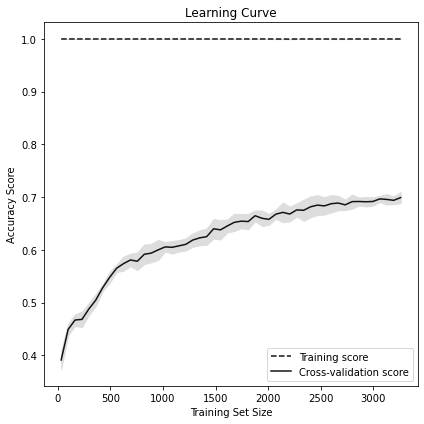

In [8]:
plt.subplots(1, figsize=(6,6))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Grafik Hyperparameter yang Optimal

In [ ]:
search_space= {
    "n_estimators": [10,20,50,100,300],
    "min_samples_split":[2,3,4,5,10,20,30,50],
    "min_samples_leaf":[1,2,3,4,5,10,20,30,50]
}
def get_graph(params):
    n = pd.DataFrame({params:[],
                  "accuracy":[]})
    for i in range (len(search_space[params])):
        rfn=RandomForestClassifier(n_estimators=search_space[params][i],random_state=2)
        rfn.fit(x_train,y_train)
        y_pred = rfn.predict(x_test)
        score = accuracy_score(y_pred,y_test)
        n=n.append({params:search_space[params][i],'accuracy':score},ignore_index=True)
    plt.plot(n[params], n["accuracy"])
    plt.title(params)
    plt.xlabel(params)
    plt.ylabel("model accuracy")
    return plt

c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: D

<module 'matplotlib.pyplot' from 'c:\\Users\\nadira Fawziyya m\\Anaconda3\\envs\\gee\\lib\\site-packages\\matplotlib\\pyplot.py'>

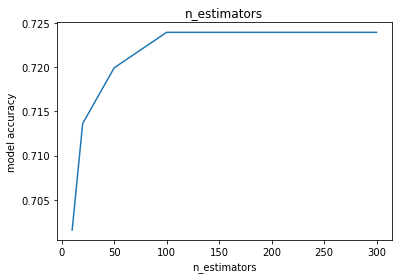

In [ ]:
get_graph("n_estimators")

c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: D

<module 'matplotlib.pyplot' from 'c:\\Users\\nadira Fawziyya m\\Anaconda3\\envs\\gee\\lib\\site-packages\\matplotlib\\pyplot.py'>

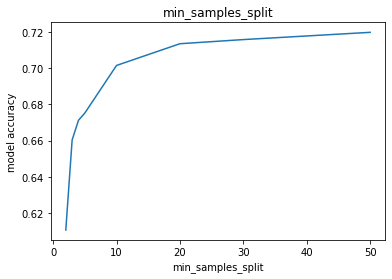

In [ ]:
get_graph("min_samples_split")

c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
c:\Users\nadira Fawziyya m\Anaconda3\envs\gee\lib\site-packages\ipykernel_launcher.py:11: D

<module 'matplotlib.pyplot' from 'c:\\Users\\nadira Fawziyya m\\Anaconda3\\envs\\gee\\lib\\site-packages\\matplotlib\\pyplot.py'>

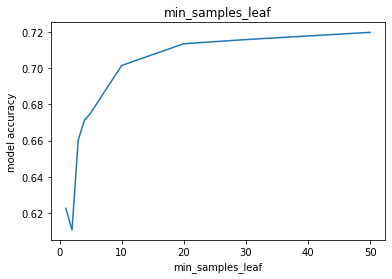

In [ ]:
get_graph("min_samples_leaf")

# Prediksi area Jaktim

In [2]:
feature_names = ['NDVI','NDBI','MNDWI','UI','BI']
label = "nilai"
out_dir = os.path.expanduser("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\")

In [ ]:
# get the features and labels into separate variables
x = df[feature_names]
y = df[label]
# create a classifier and fit
rf = ensemble.RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=100).fit(x, y)

#Export the model
filename = 'finalized_model.sav'
out_shp1 = os.path.join(out_dir, filename)
pickle.dump(rf, open(out_shp1, 'wb'))

In [3]:
# load the model
filename = 'finalized_model.sav'
out_dir = os.path.expanduser("C:\\Users\\nadira Fawziyya m\\Documents\\KULIAH\\Sem 8\\Siscer\\TUBES\\DATA\\")
out_shp1 = os.path.join(out_dir, filename)
rf = pickle.load(open(out_shp1, 'rb'))

In [63]:
# menguji akurasi
rf.score(x_test,y_test)

1.0

In [64]:
# convert the estimator into a list of strings
trees = ml.rf_to_strings(rf, feature_names)

# number of trees we converted should equal the number of trees we defined for the model
n_trees = 100
len(trees) == n_trees
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [74]:
finLayer, bandsall, label = get_L8(2013, "prediksi")
finLayer = finLayer.rename(["NDVI","NDBI","MNDWI","UI","BI"])


In [66]:
# Predict finLayer dengan model yang telah dibangun (ee_classifier)
classified = finLayer.select(feature_names).classify(ee_classifier)

In [67]:
# display results
palette = ['blue', 'green', 'yellow', 'red']
# blue : badan air
# green: vegetasi
# yellow: lain-lainnya
# red: pemukiman dan jalanan

In [68]:
# Menambahkan Layer ke Map
Map.addLayer(classified, {'min': 0, 'max':3, 'palette': palette}, 'classified')

EEException: Request payload size exceeds the limit: 10485760 bytes.

Apabila error, hal ini dikarenakan image yang ingin ditambahkan ke layer map melebihi batasan ukuran file. 
Bagian ini dapat dilakukan di google earth engine dengan menjalankan kode pada link berikut:
https://code.earthengine.google.com/e5fd351633b2aecde7208678d1f77f37
dengan menekan tombol run dan memilih layer map yang ingin dilihat.

In [71]:
# Showing Map
Map

# pindahkan area layar map ke bagian area jakarta. Lalu pilih Layer 'classified'

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
# Menghitung luas area
# df2 = geemap.image_area_by_group(
#     classified, scale=500, denominator=1e6, decimal_places=4, verbose=True
# )
# df2 #satuannya km kuadrat

In [75]:
# Untuk melihat layer band lainnya

#Params
ndviParams = {"min": -1, "max": 1, "palette": ['blue', 'white', 'green']}
ndbiParams = {"min":-1, "max":1, "palette":["#F07F0E", "#ff0000", "#404040","#000000"]}
mndwiParams = {"min":-1, "max":1, "palette":["red","cyan","green","blue"]}
uiParams = {"min":-1, "max":1, "palette":["#F2F2F2","#BABABA","#7F7F7F","#000000"]}
biParams = {"min":-1, "max":1, "palette":["#F7E181","#FFBC85","#C55A11","#000000"]}

# Add Layer to Map
Map.addLayer(finLayer.select("NDVI"),ndviParams,'NDVI')
Map.addLayer(finLayer.select("NDBI"),ndbiParams,'NDBI')
Map.addLayer(finLayer.select("MNDWI"),mndwiParams,'MNDWI')
Map.addLayer(finLayer.select("UI"),uiParams,'UI')
Map.addLayer(finLayer.select("BI"),biParams,'BI')
Map # show the map

Map(bottom=300.0, center=[86.76812147009143, 126.55989385341863], controls=(WidgetControl(options=['position',…

Data Tambahan: LST, NDVI, UTFVI

In [76]:
start_date, finish_date = get_bulan(2013) # diubah sesuai kebutuhan (2013/2015/2017/2019/2021)
collectionL8 = ee.ImageCollection(L8).map(func_predict) \
        .filterDate(start_date, finish_date) \
        .filterMetadata('CLOUD_COVER', 'less_than', 5) \
        .select(LC8_BANDS) \
        .filterBounds(polygon) \

col2 = collectionL8.select('B2').median()
col3 = collectionL8.select('B3').median()
col4 = collectionL8.select('B4').median()
col5 = collectionL8.select('B5').median()
col6 = collectionL8.select('B6').median()
col7 = collectionL8.select('B7').median()
col10 =collectionL8.select('B10').median()

NDVI1 = col5.subtract(col4)
NDVI2 = col5.add(col4)
NDVI = NDVI1.divide(NDVI2)

minNDVI = ee.Number(NDVI.reduceRegion(reducer= ee.Reducer.min(),geometry=polygon,scale= 30, maxPixels= 1e9).values().get(0))
maxNDVI = ee.Number(NDVI.reduceRegion(reducer= ee.Reducer.max(),geometry=polygon,scale= 30,maxPixels= 1e9).values().get(0))

thermal= col10.multiply(0.1)
# Emissivity
m= ee.Number(0.004)
n= ee.Number(0.986)
fv =(NDVI.subtract(minNDVI).divide(maxNDVI.subtract(minNDVI))).pow(ee.Number(2)).rename('FV')
EM=fv.multiply(m).add(n).rename('EMM')


# LST in Celsius Degree bring -273.15
LST = thermal.expression(
'(Tb/(1 + (0.00115* (Tb / 1.438))*log(Ep)))-273.15', {
 'Tb': thermal.select('B10'),
'Ep': EM.select('EMM')
}).rename('LST')

# min max mean LST
minLST = ee.Number(LST.reduceRegion(reducer= ee.Reducer.min(),geometry=polygon,scale= 30,maxPixels= 1e9).values().get(0))
maxLST = ee.Number(LST.reduceRegion(reducer= ee.Reducer.max(),geometry=polygon,scale= 30,maxPixels= 1e9).values().get(0))
meanLST = ee.Number(LST.reduceRegion(reducer= ee.Reducer.mean(),geometry=polygon,scale= 30,maxPixels= 1e9).values().get(0))

# Urban Thermal Field Variance Index
UTFVI1 = LST.subtract(meanLST)
UTFVI= UTFVI1.divide(LST)

fincol1 = ee.ImageCollection([UTFVI,LST, NDVI])
finLayer1 = fincol1.toBands()
finLayer1 = finLayer1.rename(["UTFVI","LST","NDVI"])

In [77]:
# LST

LSTimage = finLayer1.select("LST")
LST0 = LSTimage.lt(20)
LST1 = LSTimage.gte(20).And(LSTimage.lt(25))
LST2 = LSTimage.gte(25).And(LSTimage.lt(30))
LST3 = LSTimage.gte(30).And(LSTimage.lt(35))
LST4 = LSTimage.gte(35).And(LSTimage.lt(40))
LST5 = LSTimage.gte(40).And(LSTimage.lt(45))
LST6 = LSTimage.gte(45)
maskedLST0 = LSTimage.updateMask(LST0)
maskedLST1 = LSTimage.updateMask(LST1)
maskedLST2 = LSTimage.updateMask(LST2)
maskedLST3 = LSTimage.updateMask(LST3)
maskedLST4 = LSTimage.updateMask(LST4)
maskedLST5 = LSTimage.updateMask(LST5)
maskedLST6 = LSTimage.updateMask(LST6)

# show map
Map.addLayer(maskedLST0,{"min":0,"max":20,"palette":"#8DB538"},'LST0')
Map.addLayer(maskedLST1,{"min":20,"max":25,"palette":"#BBD140"},'LST1')
Map.addLayer(maskedLST2,{"min":25,"max":30,"palette":"#FFED4A"},'LST2')
Map.addLayer(maskedLST3,{"min":30,"max":35,"palette":"#FFC73C"},'LST3')
Map.addLayer(maskedLST4,{"min":35,"max":40,"palette":"#FFA130"},'LST4')
Map.addLayer(maskedLST5,{"min":40,"max":45,"palette":"#FF7626"},'LST5')
Map.addLayer(maskedLST6,{"min":45,"palette":"red"},'LST6')

In [78]:
# NDVI
ndvi = finLayer1.select("NDVI")
NDVI0 = ndvi.lte(0)
NDVI1 = ndvi.gt(0).And(ndvi.lte(0.16))
NDVI2 = ndvi.gt(0.16).And(ndvi.lte(0.32))
NDVI3 = ndvi.gt(0.32).And(ndvi.lte(0.48))
NDVI4 = ndvi.gt(0.48).And(ndvi.lte(0.64))
NDVI5 = ndvi.gt(0.64)
maskedndvi0 = ndvi.updateMask(NDVI0)
maskedndvi1 = ndvi.updateMask(NDVI1)
maskedndvi2 = ndvi.updateMask(NDVI2)
maskedndvi3 = ndvi.updateMask(NDVI3)
maskedndvi4 = ndvi.updateMask(NDVI4)
maskedndvi5 = ndvi.updateMask(NDVI5)

# Add layer map
Map.addLayer(maskedndvi0,{"max":0,"palette":"#422112"},'ndvi0')
Map.addLayer(maskedndvi1,{"min":0,"max":0.16,"palette":"#9F5129"},'ndvi1')
Map.addLayer(maskedndvi2,{"min":0.16,"max":0.32,"palette":"#CDA915"},'ndvi2')
Map.addLayer(maskedndvi3,{"min":0.32,"max":0.48,"palette":"#CFDD01"},'ndvi3')
Map.addLayer(maskedndvi4,{"min":0.48,"max":0.64,"palette":"#5C8E02"},'ndvi4')
Map.addLayer(maskedndvi5,{"min":0.64,"palette":"#176100"},'ndvi5')

In [79]:
# UTFVI
UTFVI = finLayer1.select('UTFVI')
UTFVI0 = UTFVI.lt(0)
UTFVI1 = UTFVI.gte(0).And(UTFVI.lt(0.005))
UTFVI2 = UTFVI.gte(0.005).And(UTFVI.lt(0.010))
UTFVI3 = UTFVI.gte(0.010).And(UTFVI.lt(0.015))
UTFVI4 = UTFVI.gte(0.015).And(UTFVI.lt(0.020))
UTFVI5 = UTFVI.gt(0.020)
maskedUTFVI0 = UTFVI.updateMask(UTFVI0)
maskedUTFVI1 = UTFVI.updateMask(UTFVI1)
maskedUTFVI2 = UTFVI.updateMask(UTFVI2)
maskedUTFVI3 = UTFVI.updateMask(UTFVI3)
maskedUTFVI4 = UTFVI.updateMask(UTFVI4)
maskedUTFVI5 = UTFVI.updateMask(UTFVI5)

# Add Layer Map
Map.addLayer(maskedUTFVI0,{"max":0,"palette":"#009200"},'UHI-None')
Map.addLayer(maskedUTFVI1,{"min":0,"max":0.005,"palette":"#5EB000"},'UHI-Weak')
Map.addLayer(maskedUTFVI2,{"min":0.005,"max":0.010,"palette":"#CFD500"},'UHI-Middle')
Map.addLayer(maskedUTFVI3,{"min":0.010,"max":0.015,"palette":"#FFC500"},'UHI-Strong')
Map.addLayer(maskedUTFVI4,{"min":0.015,"max":0.020,"palette":"#FF6200"},'UHI-Stronger')
Map.addLayer(maskedUTFVI5,{"min":0.020,"palette":"#EC0000"},'UHI-Strongest')

Perhitungan luas dilakukan di google earth engine dengan link kode sebagai berikut:
https://code.earthengine.google.com/317762a5697759db756fa1e9089d9ca2

Perhitungan luas tidak dilakukan di jupyter notebook karena saat melakukan print angka luasan area
selalu menghasilkan kalimat panjang yang tidak menunjukkan angka luasan.
Oleh karena itu, perhitungan luas, minNDVI, maxNDVI, minLST, dan maxLST ditampilkan melalui eksekusi link kode di atas

In [80]:
Map
# pilih layer map dengan mengklik toolbar di pojok kanan dan klik tombol layer yang muncul di samping kirinya.
# Lalu geser area map ke area Jakarta Timur

Map(bottom=592.0, center=[82.26169873683153, 131.66015625000003], controls=(WidgetControl(options=['position',…

# Sekian, terima kasih.